<IPython.core.display.Javascript object>


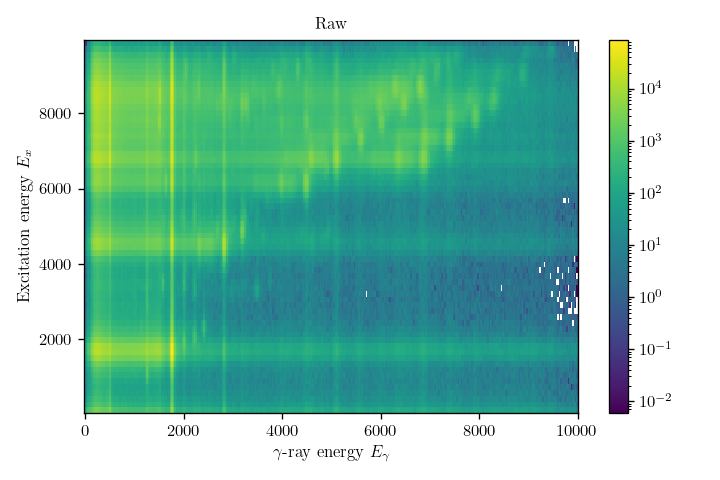

<IPython.core.display.Javascript object>


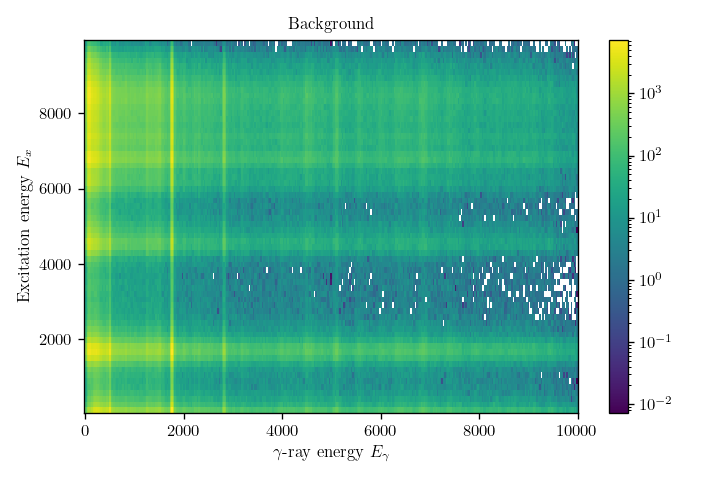

<IPython.core.display.Javascript object>


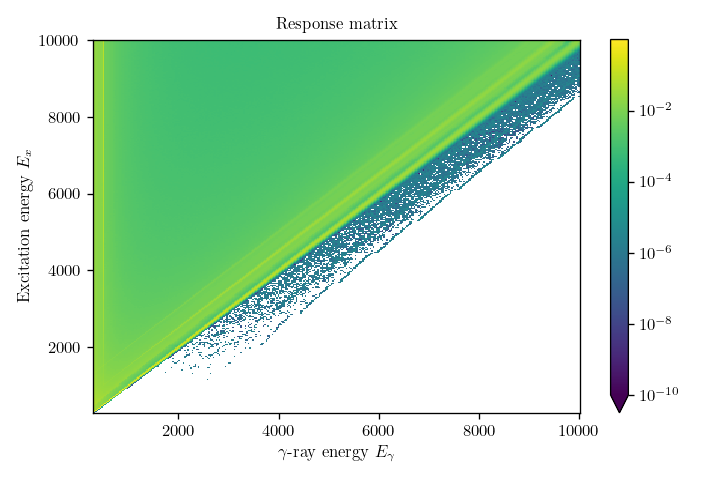

In [9]:
%matplotlib notebook
%matplotlib notebook
import numpy as np
import ompy as om
import fbu
import scipy.stats as st
import pymc3 as mc
import matplotlib.pyplot as plt
import matplotlib as mpl
import scipy as sp
from matplotlib import rc

dpi = 120
rc('figure',dpi = dpi)
rc('font', **{'family': 'serif', 'serif': ['Computer Modern']})
rc('text', usetex=True)
rc('figure', figsize = (6,4))
rc('font', size=10)
rc('legend', fontsize = 10)
rc('axes', labelsize = 10)
rc('axes', titlesize = 10)
rc('xtick', labelsize = 10)
rc('ytick', labelsize = 10)

folderpath = "../../../ompy/OCL_response_functions/oscar2020/ompy_interpolate"
response = om.Response(folderpath)

raw = om.Matrix(path="../Datafiles/h_Ex_Eg_28Si.m")
# Background from file
bg = 1.2*om.Matrix(path="../Datafiles/h_Ex_Eg_bg_28Si.m")

raw.cut('Ex',0, 10000)
raw.cut('Eg', 0, 10000)
raw.rebin(axis= "Eg", factor=3)
bg.cut('Ex',0, 10000)
bg.cut('Eg', 0, 10000)
bg.rebin(axis= "Eg", factor=3)


Eg = raw.Eg
energy = Eg

# Cutting the first 8 bins where the response has increased errors
###
energy = Eg[10:]
energy_bins = range(len(Eg))[10:]
###


raw.plot(title = 'Raw')
plt.tight_layout()
bg.plot(title = 'Background')
plt.tight_layout()
response_mat, R_tab_bay= response.interpolate(energy, fwhm_abs=30, return_table = True)

response_mat.plot(title="Response matrix", scale='log', vmin = 1e-10)

resp = response_mat.values

plt.tight_layout()
Emin = 1400
Emax = 2200
raw_folded, E = raw.projection(axis="Eg", Emin=Emin, Emax=Emax)
background, E = bg.projection(axis="Eg", Emin=Emin, Emax=Emax) 

# Cutting the first 10 bins where the response has increased errors
###
raw_folded = raw_folded[10:]
background = background[10:]
###

<IPython.core.display.Javascript object>


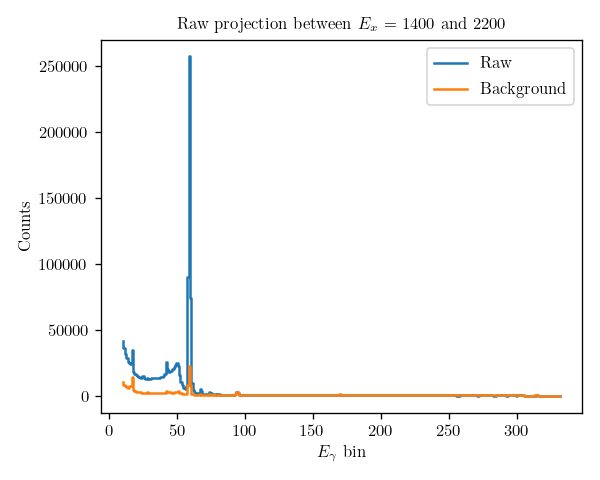

1422148.2530120492


In [11]:
%matplotlib notebook
%matplotlib notebook


plt.figure(figsize = (5,4))
plt.step(energy_bins,raw_folded, label = 'Raw', where  = 'mid')
plt.step(energy_bins,background, label = 'Background', where  = 'mid')

plt.title(r'Raw projection between $E_x$ = {} and {}'.format(Emin,Emax))
# plt.yscale('log')
plt.ylabel(r'Counts')
plt.xlabel(r'$E_\gamma$ bin')
plt.legend()
plt.tight_layout()
print(np.sum(raw_folded))
plt.show()

In [12]:
prior_l = np.ones(len(raw_folded))*1e-1

prior_u = np.maximum(raw_folded*10, 100*prior_l)

In [13]:
# Initiating FBU:
myfbu = fbu.PyFBU()
myfbu.response = resp
myfbu.data = raw_folded
myfbu.upper = prior_u   
myfbu.lower = prior_l

myfbu.background = {'bckg1': background}
myfbu.backgroundsyst = {'bckg1':0}


prior_choice = 1
# Standard uniform prior
if prior_choice == 0:
    myfbu.prior = 'Uniform'
    prior_random_sampling = st.uniform.rvs
    a = prior_l
    b = prior_u
    
    prior_args = [a,b]
    # No additional parameters
    prior_kwargs = dict()
    myfbu.priorparams = dict()

# Interpolated
if prior_choice == 1:
    myfbu.prior = 'Interpolated'
    x_values = []
    pdf_values = []
    for i in range(len(raw_folded)):
        x_temp = np.logspace(np.log10(prior_l[i]), np.log10(prior_u[i]), num = 10000)
        x_values.append(x_temp)
        pdf_values.append(1.0/x_temp)
        
    
    myfbu.priorparams = dict(non_kwargs=[x_values, pdf_values])
    # Arguments for prior sampling below, none needed
    prior_kwargs = dict()
    prior_args = []

In [14]:
print('Prior choice:', prior_choice)
myfbu.nTune = 1000
myfbu.nMCMC = 5000
myfbu.nChains = 2
# myfbu.nTune = 100000
# myfbu.nMCMC = 500000

myfbu.nCores = 4
myfbu.run()

Prior choice: 1
prior start
prior done


Auto-assigning NUTS sampler...
Initializing NUTS using advi+adapt_diag...


None


Average Loss = 4,821.2:  46%|████▋     | 92999/200000 [25:14<29:02, 61.42it/s]     
Convergence achieved at 93000
Interrupted at 92,999 [46%]: Average Loss = 2.5457e+05
Multiprocess sampling (2 chains in 4 jobs)
NUTS: [gaus_bckg1, truth322, truth321, truth320, truth319, truth318, truth317, truth316, truth315, truth314, truth313, truth312, truth311, truth310, truth309, truth308, truth307, truth306, truth305, truth304, truth303, truth302, truth301, truth300, truth299, truth298, truth297, truth296, truth295, truth294, truth293, truth292, truth291, truth290, truth289, truth288, truth287, truth286, truth285, truth284, truth283, truth282, truth281, truth280, truth279, truth278, truth277, truth276, truth275, truth274, truth273, truth272, truth271, truth270, truth269, truth268, truth267, truth266, truth265, truth264, truth263, truth262, truth261, truth260, truth259, truth258, truth257, truth256, truth255, truth254, truth253, truth252, truth251, truth250, truth249, truth248, truth247, truth246,

Elapsed 2:13:39 (1.50 samples/second)


In [15]:
#Trace containing all the posteriors.
#Retrieves the N-dimensional posterior distribution in the form of a list of N arrays.
trace = myfbu.trace


In [16]:
# Calculating the HPD interval using PyMC3
hpd = mc.stats.hpd(np.array(trace).T, alpha = 1-0.68)   
means = np.mean(trace, axis = 1)
median = np.median(trace, axis = 1)

Unfolded bin 49: 782270.4862688709 + rest: 328889.51267700567 = 1111159.9989458765


<IPython.core.display.Javascript object>


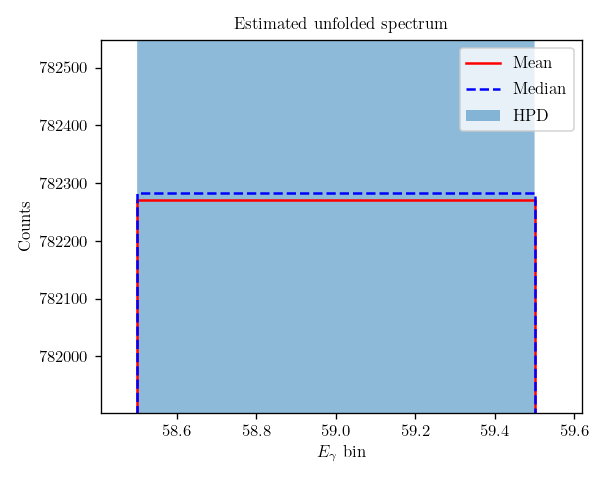

In [47]:
%matplotlib notebook
%matplotlib notebook

print('Unfolded bin {}: {} + rest: {} = {}'.format(np.argmax(means), 
                                                   means[np.argmax(means)],
                                                   np.sum(means[:np.argmax(means)]) + 
                                                   np.sum(means[np.argmax(means)+1:]),
                                                   means[np.argmax(means)]+
                                                   np.sum(means[:np.argmax(means)]) + 
                                                   np.sum(means[np.argmax(means)+1:]))
)
# Plots with bin number on x-axis
plt.figure(figsize = (5,4))
plt.step(energy_bins, means, alpha = 1, ls='-', color = 'red', label = r'Mean', where = 'mid')
plt.fill_between(x = energy_bins, y1 = hpd[:,0], y2 = hpd[:,1], step = 'mid', alpha=0.5, label =r'HPD')
plt.step(energy_bins, median, ls='--', color = 'blue', alpha = 1, label = 'Median', where = 'mid')




# plt.yscale('log')
plt.ylabel('Counts')
plt.xlabel('$E_\gamma$ bin')
plt.title('Estimated unfolded spectrum')
plt.legend()

import matplotlib.lines as mlines

plt.legend()
plt.tight_layout()


plt.show()



In [38]:
# %matplotlib notebook
# %matplotlib notebook



# plt.figure(figsize = (5,4))
# # Folding all posterior samples
# trace_array = np.array(trace)
# # folded_samples = trace_array.T@resp

# listtt = []
# for i in range(len(trace[0])):
#     listtt.append(trace_array.T[i]@resp)
# folded_samples = np.array(listtt)

# # Calculating the HPD interval using PyMC3, and its mean
# folded_hpd = mc.stats.hpd(folded_samples, alpha = 1-0.68)   
# folded_means = np.mean(folded_samples, axis = 0)
# folded_medians = np.median(folded_samples.T, axis = 1)

# print('Unfolded bin {}: {} + rest: {} = {}'.format(np.argmax(folded_means), 
#                                                    folded_means[np.argmax(folded_means)],
#                                                    np.sum(folded_means[:np.argmax(folded_means)]) + 
#                                                    np.sum(folded_means[np.argmax(folded_means)+1:]),
#                                                    folded_means[np.argmax(folded_means)]+
#                                                    np.sum(folded_means[:np.argmax(folded_means)]) + 
#                                                    np.sum(folded_means[np.argmax(folded_means)+1:]))
# )


# plt.step(range(len(energy)), raw_folded, label='Raw', color = 'black', where = 'mid')
# plt.step(range(len(energy)), folded_means + background , color = 'red', alpha = 1, ls='-', label = r'Mean + BG', where = 'mid')
# plt.fill_between(x = range(len(energy)), y1 = folded_hpd[:,0] + background, y2 = folded_hpd[:,1] + background, step = 'mid', alpha=0.5, label =r'HPD + BG')
# plt.step(range(len(energy)), folded_medians + background, ls='--', color = 'blue', alpha = 1, label = 'Median + BG', where = 'mid')
# plt.ticklabel_format(axis = 'y', style = 'sci', scilimits = (0,4))
# ###
# # plt.step(range(len(energy)), prior_u@resp, label = 'Upper prior')
# ###
# plt.title('Observed raw spectrum compared with estimates of the folded samples')
# plt.ylabel('Counts')
# plt.xlabel(r'E$\gamma$ bin')
# plt.legend(facecolor='grey', framealpha=0.2)
# # plt.tight_layout()
# plt.show()

# print('Mean absolute errors:')
# print('---------------------')
# print('Mean:', np.mean(np.abs(raw_folded - (folded_means + background))))
# print('Median:', np.mean(np.abs(raw_folded - (folded_medians + background))))

# print('\nR2-scores:')
# print('---------------------')
# print('Mean:', 1 - (np.sum((raw_folded - (folded_means + background))**2))/(np.sum((raw_folded - np.mean(raw_folded))**2)))
# print('Median:', 1 - (np.sum((raw_folded - (folded_medians + background))**2))/(np.sum((raw_folded - np.mean(raw_folded))**2)))


<IPython.core.display.Javascript object>


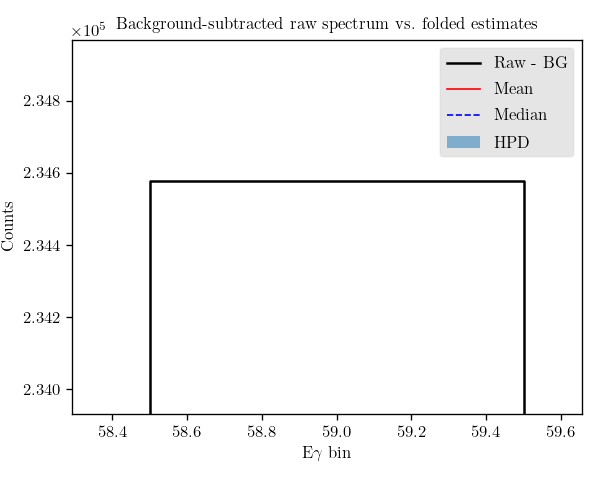

Mean absolute errors:
---------------------
Mean: 208.92775602269865
Median: 209.86046149271476

R2-scores:
---------------------
Mean: 0.99705943383727
Median: 0.9970980654778191


In [48]:
%matplotlib notebook
%matplotlib notebook
plt.figure(figsize = (5,4))


# Compare the folded estimates with the raw spectrum
plt.step(energy_bins, raw_folded - background, label='Raw - BG', color = 'black', where = 'mid')
plt.step(energy_bins, means@resp, color = 'red', ls='-', linewidth = 1, label = r'Mean', where = 'mid')
plt.step(energy_bins, median@resp, ls='--', color = 'blue', linewidth = 1, label = 'Median', where = 'mid')
plt.fill_between(x = energy_bins, y1 = (hpd[:,0])@resp, y2 = (hpd[:,1])@resp, step = 'mid', alpha=0.5, label =r'HPD')
plt.ticklabel_format(axis = 'y', style = 'sci', scilimits = (0,4))


# plt.yscale('log')
plt.title('Background-subtracted raw spectrum vs. folded estimates')
plt.ylabel('Counts')
plt.xlabel(r'E$\gamma$ bin')
plt.legend(facecolor='grey', framealpha=0.2)
plt.tight_layout()
plt.show()

print('Mean absolute errors:')
print('---------------------')
print('Mean:', np.mean(np.abs(raw_folded - (means@resp + background))))
print('Median:', np.mean(np.abs(raw_folded - (median@resp + background))))

print('\nR2-scores:')
print('---------------------')
print('Mean:', 1 - (np.sum((raw_folded - (means@resp + background))**2))/(np.sum((raw_folded - np.mean(raw_folded))**2)))
print('Median:', 1 - (np.sum((raw_folded - (median@resp + background))**2))/(np.sum((raw_folded - np.mean(raw_folded))**2)))


<IPython.core.display.Javascript object>


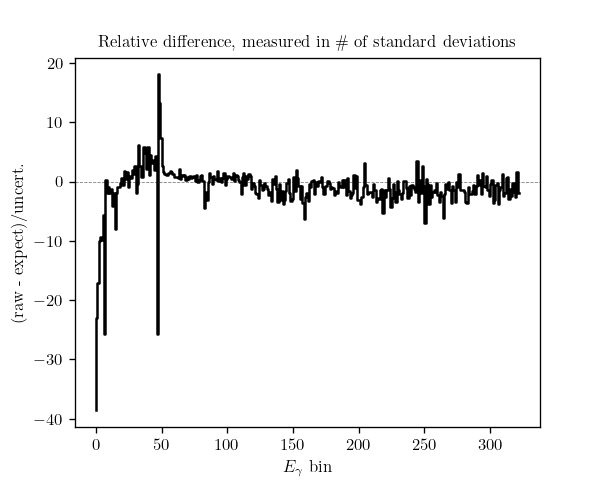

In [49]:
%matplotlib notebook
%matplotlib notebook

sigma_folded = np.std(folded_samples, axis = 0)
# Do not know if we have access to sigma_background, set to 0 
sigma_background = 0
sigma_stat = np.sqrt(raw_folded)
sigma_total = np.sqrt( sigma_stat**2 + sigma_folded**2 + sigma_background**2 )


plt.figure(figsize = (5,4))
plt.ylabel('(raw - expect)/uncert.')
plt.xlabel(r'$E_\gamma$ bin')
plt.title('Relative difference, measured in \# of standard deviations')

plt.axhline(y=0, color='grey', linestyle='--', alpha = 1, linewidth = 0.5)
plt.step(range(len(energy)), (raw_folded - folded_means - background) / sigma_total, label='sigma', color = 'black')

plt.show()

In [43]:
# %matplotlib notebook
# %matplotlib notebook
# # Residual plot
# plt.figure(figsize = (5,4))
# plt.step(energy_bins,raw_folded - (folded_means + background), color = 'red', ls='-', linewidth = 1, label = r'Raw - Mean + BG', where = 'mid')
# plt.step(energy_bins,raw_folded - (folded_medians + background), ls='--', color = 'blue', linewidth = 1, label = 'Raw - Median + BG', where = 'mid')
# plt.axhline(y=0, color='grey', linestyle='--', alpha = 1, linewidth = 0.5)

# plt.title('Residual plot for estimates of the folded samples')
# plt.ylabel('Residual')
# plt.xlabel(r'E$\gamma$ bin')
# plt.legend(facecolor='grey', framealpha=0.2)
# plt.tight_layout()
# plt.show()

# print(np.sum(np.abs(raw_folded - (folded_means + background))))
# print(np.sum(np.abs(raw_folded - (folded_medians + background))))

<IPython.core.display.Javascript object>


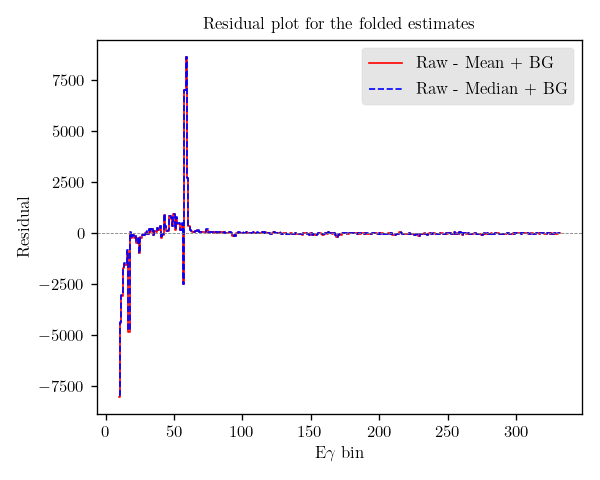

In [42]:
%matplotlib notebook
%matplotlib notebook
plt.figure(figsize = (5,4))
# Residual plot
plt.step(energy_bins,raw_folded - (means@resp + background), color = 'red', ls='-', linewidth = 1, label = r'Raw - Mean + BG', where = 'mid')
plt.step(energy_bins,raw_folded - (median@resp + background), ls='--', color = 'blue', linewidth = 1, label = 'Raw - Median + BG', where = 'mid')
plt.axhline(y=0, color='grey', linestyle='--', alpha = 1, linewidth = 0.5)

plt.title('Residual plot for the folded estimates')
plt.ylabel('Residual')
plt.xlabel(r'E$\gamma$ bin')
plt.legend(facecolor='grey', framealpha=0.2)
plt.tight_layout()

plt.show()

<IPython.core.display.Javascript object>


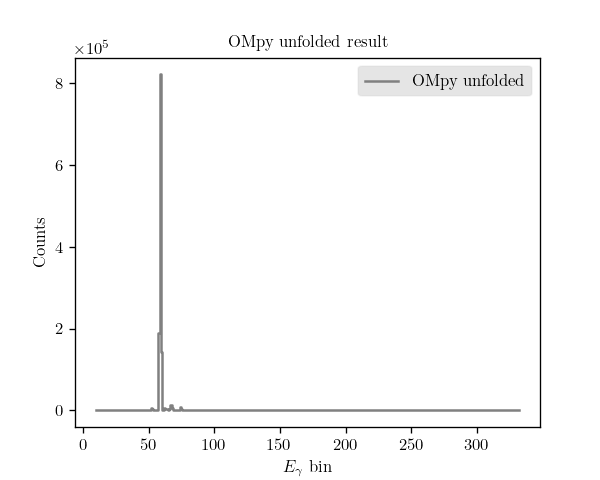

<IPython.core.display.Javascript object>


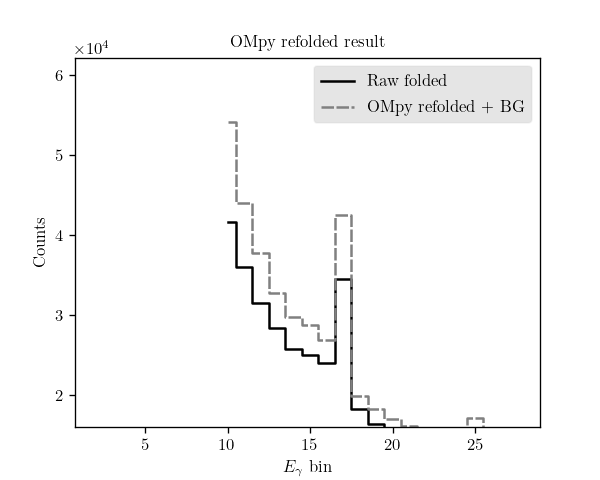

Mean absolute errors:
---------------------
Folded: 1573.4365285743422

R2-scores:
---------------------
Folded: 0.9616761295423951


In [44]:
# Folding iteration method
%matplotlib notebook
%matplotlib notebook

ompy_raw_bg_subtracted = raw_folded - background

response_ompy, table = response.interpolate(energy, fwhm_abs=30, return_table=True)

# The ompy unfolder requires a mock matrix if unfolding a 1D spectrum
ompy_raw = om.Matrix(np.array([ompy_raw_bg_subtracted, ompy_raw_bg_subtracted]), Eg = energy)
#
ompy_raw.remove_negative()
#
ompy_unfolder = om.Unfolder(response=response_ompy)
# Required for compton subtraction
ompy_unfolder.response_tab = table 


# The output is a tuple of 2 identical unfolded spectra, get the first
ompy_unfolded = ompy_unfolder(ompy_raw)[0]
ompy_folded = ompy_unfolded@response_ompy.values

unfolded_shortened = ompy_unfolded
folded_shortened = ompy_folded

plt.figure(figsize = (5,4))
plt.step(energy_bins, unfolded_shortened, color = 'grey', ls = '-', label = 'OMpy unfolded', where = 'mid')
plt.xlabel(r'$E_{\gamma}$ bin')
plt.ylabel('Counts')
plt.legend(facecolor='grey', framealpha=0.2)
plt.title('OMpy unfolded result')
plt.ticklabel_format(axis = 'y', style = 'sci', scilimits = (0,4))

raw_no_zeros = ompy_raw_bg_subtracted

plt.figure(figsize = (5,4))
plt.step(energy_bins,raw_no_zeros + background, color = 'black', label = 'Raw folded', where = 'mid')
plt.step(energy_bins,folded_shortened + background, color = 'grey', dashes=(5, 1), label = 'OMpy refolded + BG', where = 'mid')
plt.xlabel(r'$E_{\gamma}$ bin')
plt.ylabel('Counts')
plt.legend(facecolor='grey', framealpha=0.2)
plt.title('OMpy refolded result')
plt.ticklabel_format(axis = 'y', style = 'sci', scilimits = (0,4))


plt.show()
print('Mean absolute errors:')
print('---------------------')
print('Folded:', np.mean(np.abs(raw_no_zeros +background - folded_shortened + background)))

print('\nR2-scores:')
print('---------------------')
print('Folded:', 1 - (np.sum((raw_no_zeros +background - folded_shortened + background)**2))/(np.sum((raw_no_zeros + background - np.mean(raw_no_zeros + background))**2)))